In [7]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

# CSV-bestanden inlezen
df_1888_1922 = pd.read_csv('eerste-zetels/Historische_zetelverdeling_Eerste_Kamer_1888-1922.csv')
df_1923_1956 = pd.read_csv('eerste-zetels/Historische_zetelverdeling_Eerste_Kamer_1923-1956.csv')
df_1956_1981 = pd.read_csv('eerste-zetels/Historische_zetelverdeling_Eerste_Kamer_1956-1981.csv')
df_1983_2023 = pd.read_csv('eerste-zetels/Historische_zetelverdeling_Eerste_Kamer_1983-2023.csv')

# Omzetten naar een long format
def melt_dataframe(df):
    return df.melt(id_vars=['Partij'], var_name='Jaar', value_name='Zetels')

df_long_1888_1922 = melt_dataframe(df_1888_1922)
df_long_1923_1956 = melt_dataframe(df_1923_1956)
df_long_1956_1981 = melt_dataframe(df_1956_1981)
df_long_1983_2023 = melt_dataframe(df_1983_2023)

# Combineer alle gesmolten dataframes
combined_long = pd.concat([df_long_1888_1922, df_long_1923_1956, df_long_1956_1981, df_long_1983_2023])

# Omzetten van jaartal en zetels naar correcte typen
combined_long['Jaar'] = combined_long['Jaar'].astype(int)
combined_long['Zetels'] = combined_long['Zetels'].fillna(0).astype(int)

# Scheiden op basis van zetelverdeling
year_threshold_1956 = 1956

df_zetels50 = combined_long[combined_long['Jaar'] < year_threshold_1956]
df_zetels75 = combined_long[combined_long['Jaar'] >= year_threshold_1956]

# Check voor het jaar 1956 moet apart behandeld worden
df_1956_in_50 = df_zetels50[df_zetels50['Jaar'] == year_threshold_1956]
df_1956_in_75 = df_zetels75[df_zetels75['Jaar'] == year_threshold_1956]

# Merge separate datasets for year 1956 back to ensure continuity
df_zetels50 = combined_long[combined_long['Jaar'] < year_threshold_1956]
df_zetels75 = combined_long[combined_long['Jaar'] >= year_threshold_1956]

# Special handling for year 1956 which is in both datasets as clarified
df_zetels75_with_1956 = pd.concat([df_zetels75, df_1956_in_75])
df_zetels50_with_1956 = pd.concat([df_zetels50, df_1956_in_50])

# Remove exact duplicate records
df_zetels50_with_1956.drop_duplicates(subset=['Jaar', 'Partij'], inplace=True)
df_zetels75_with_1956.drop_duplicates(subset=['Jaar', 'Partij'], inplace=True)

# Remove 'Totaal' records
df_zetels50_with_1956 = df_zetels50_with_1956[df_zetels50_with_1956['Partij'] != 'Totaal']
df_zetels75_with_1956 = df_zetels75_with_1956[df_zetels75_with_1956['Partij'] != 'Totaal']

# Combineer namechanges (D'66 en D66)
df_zetels50_with_1956['Partij'] = df_zetels50_with_1956['Partij'].replace("D’66", "D66")
df_zetels75_with_1956['Partij'] = df_zetels75_with_1956['Partij'].replace("D’66", "D66")

# Data output naar CSVs
df_zetels50_with_1956.to_csv('zetel-data/ek_zetels50_1888-1956.csv', index=False)
df_zetels75_with_1956.to_csv('zetel-data/ek_zetels75_1956-2023.csv', index=False)

print("Dataframes met correcte zetelverdelingen succesvol geschreven naar CSV-bestanden.")


Dataframes met correcte zetelverdelingen succesvol geschreven naar CSV-bestanden.


<Figure size 1200x800 with 0 Axes>

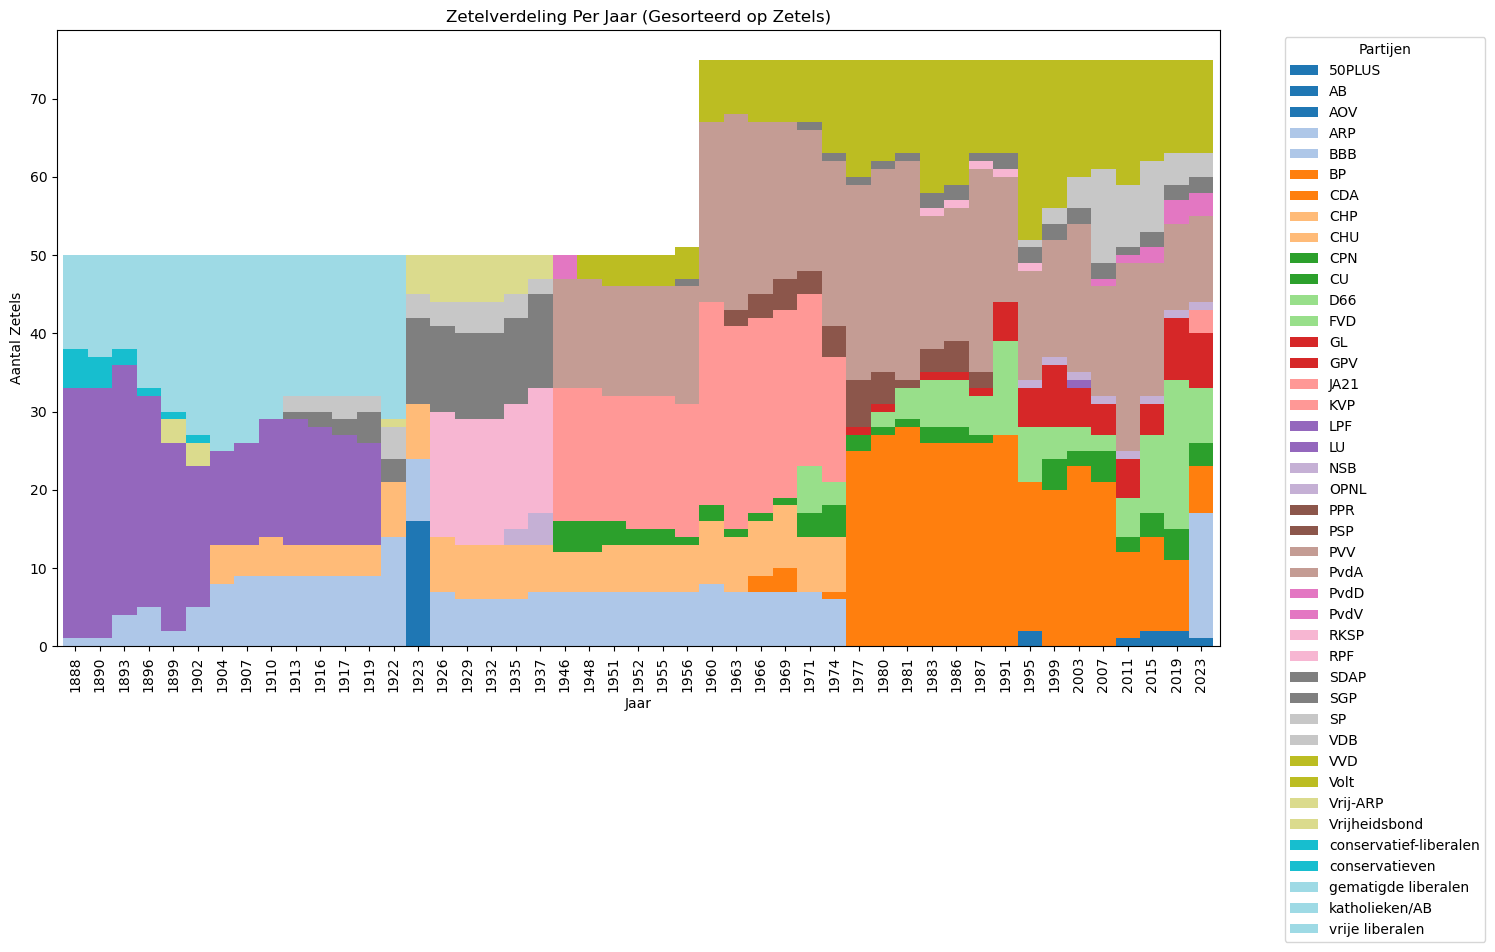

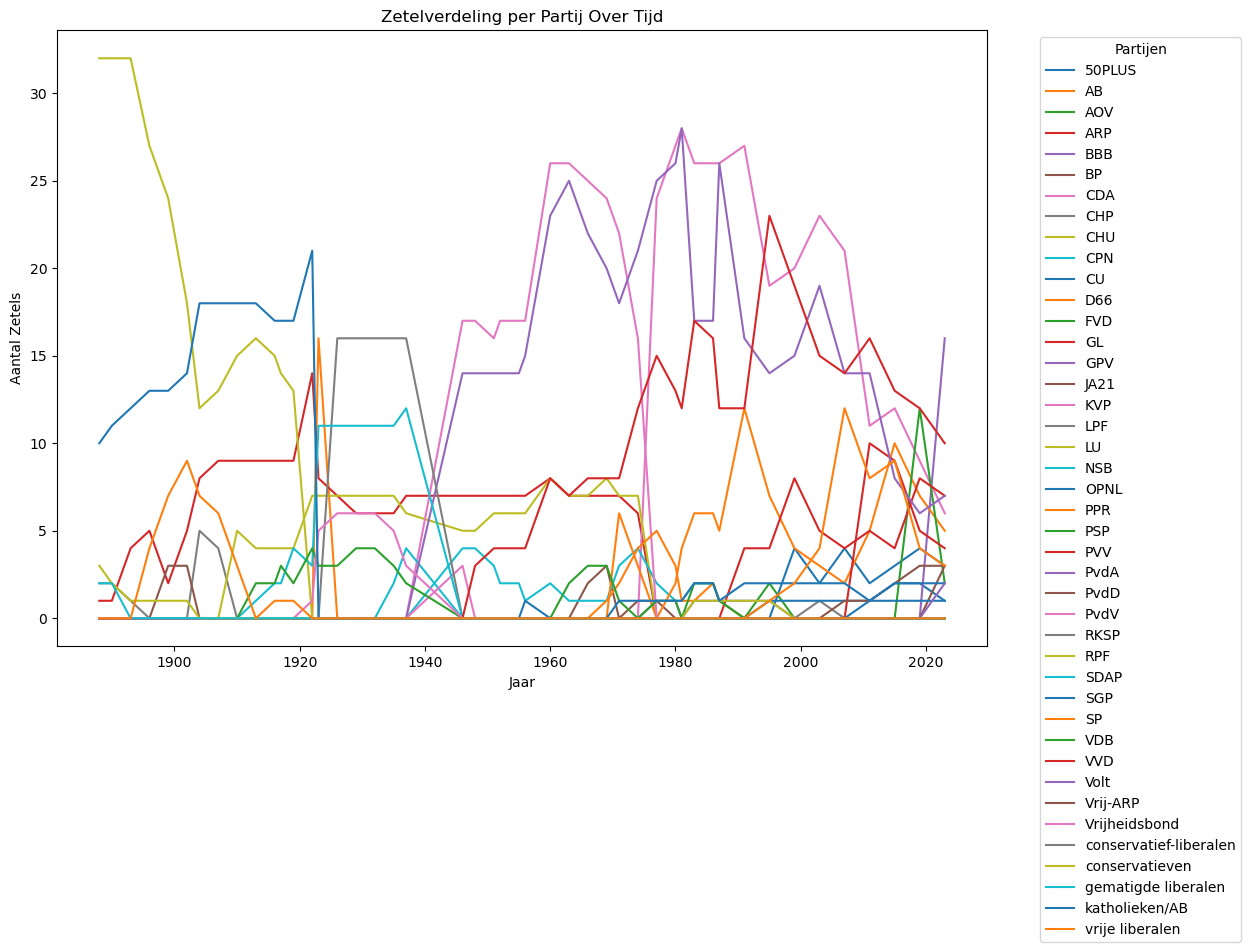

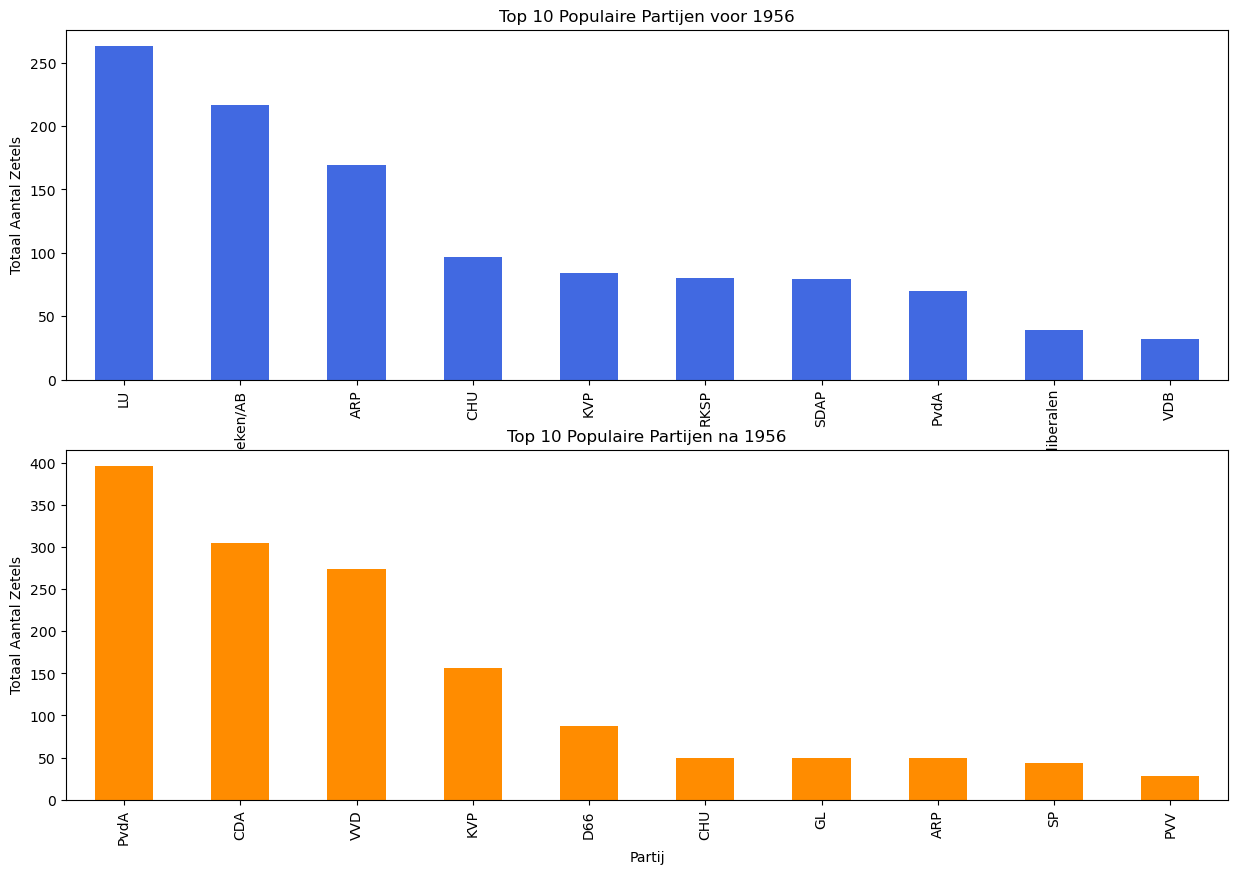

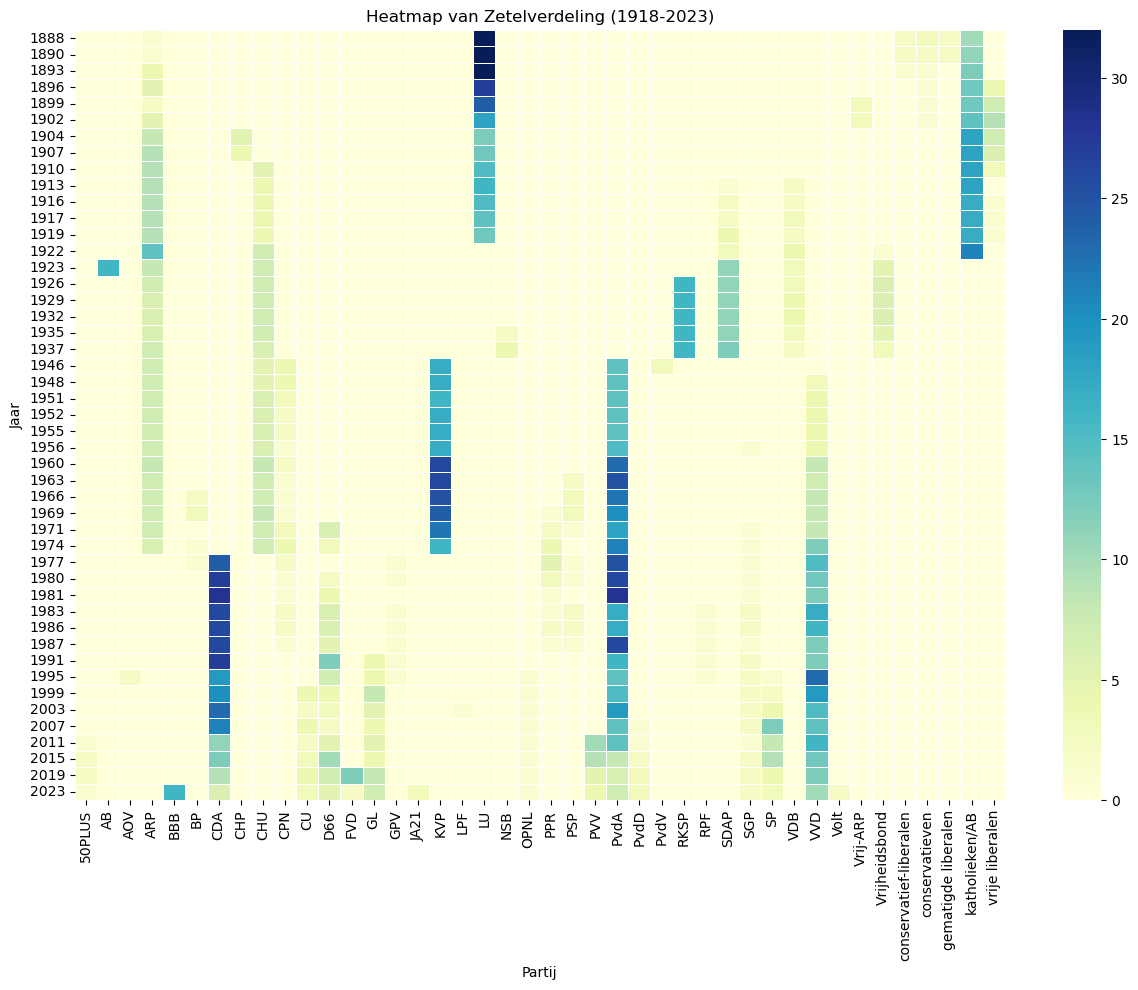

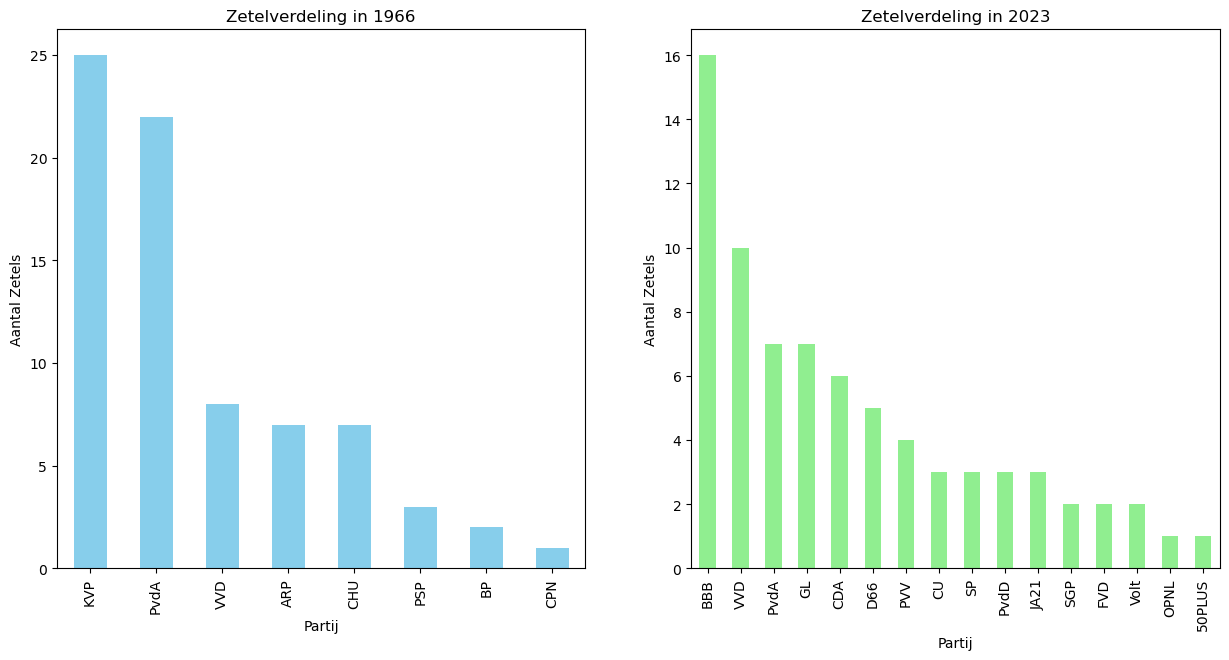

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combineer beide DataFrames voor plots
combined_df = pd.concat([df_zetels50, df_zetels75])

# 1. Stapeldiagram van Zetelverdeling Per Jaar
plt.figure(figsize=(12, 8))
df_pivot = combined_df.pivot(index='Jaar', columns='Partij', values='Zetels').fillna(0)
df_pivot.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='tab20', width=1.0)
plt.ylabel('Aantal Zetels')
plt.xlabel('Jaar')
plt.title('Zetelverdeling Per Jaar (Gesorteerd op Zetels)')
plt.legend(title='Partijen', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 2. Lijngrafiek van Partijen Over Tijd
plt.figure(figsize=(12, 8))
for partij in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[partij], label=partij)
plt.ylabel('Aantal Zetels')
plt.xlabel('Jaar')
plt.title('Zetelverdeling per Partij Over Tijd')
plt.legend(title='Partijen', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 3. Balkgrafiek van Populaire Partijen per Tijdperk
df_voor_1956 = df_zetels50.groupby('Partij')['Zetels'].sum().sort_values(ascending=False).head(10)
df_na_1956 = df_zetels75.groupby('Partij')['Zetels'].sum().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
df_voor_1956.plot(kind='bar', ax=axes[0], color='royalblue')
axes[0].set_title('Top 10 Populaire Partijen voor 1956')
axes[0].set_ylabel('Totaal Aantal Zetels')

df_na_1956.plot(kind='bar', ax=axes[1], color='darkorange')
axes[1].set_title('Top 10 Populaire Partijen na 1956')
axes[1].set_ylabel('Totaal Aantal Zetels')

plt.show()

# 4. Heatmap van Zetelverdeling
plt.figure(figsize=(15, 10))
sns.heatmap(df_pivot, cmap="YlGnBu", cbar=True, linewidths=.5)
plt.ylabel('Jaar')
plt.xlabel('Partij')
plt.title('Heatmap van Zetelverdeling (1918-2023)')
plt.show()

#  5. Barchart voor Specifieke Verkiezingen
# Voorbeelden voor de jaren 1956 en 2021
df_1966 = combined_df[(combined_df['Jaar'] == 1966) & (combined_df['Zetels'] > 0)].set_index('Partij')['Zetels'].sort_values(ascending=False)
df_2023 = combined_df[(combined_df['Jaar'] == 2023) & (combined_df['Zetels'] > 0)].set_index('Partij')['Zetels'].sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

df_1966.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Zetelverdeling in 1966')
axes[0].set_xlabel('Partij')
axes[0].set_ylabel('Aantal Zetels')

df_2023.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Zetelverdeling in 2023')
axes[1].set_xlabel('Partij')
axes[1].set_ylabel('Aantal Zetels')
plt.show()


In [11]:
df_1966 = combined_df[(combined_df['Jaar'] == 1966) & (combined_df['Zetels'] > 0)].set_index('Partij')['Zetels'].sort_values(ascending=False)
df_2023 = combined_df[(combined_df['Jaar'] == 2023) & (combined_df['Zetels'] > 0)].set_index('Partij')['Zetels'].sort_values(ascending=False)

print("Number of parties in 1966:", len(df_1966))
print("Number of parties in 2023:", len(df_2023))

Number of parties in 1966: 8
Number of parties in 2023: 16


In [19]:
import pandas as pd

# Load your CSV file
df = pd.read_csv('zetel-data/ek_zetels50_1888-1956.csv')

# To make sure the model knows the distribution for the year the second chamber elections are, I create a dataset that is filled with all years.

df = df.sort_values(by='Jaar')
years = list(range(1888, 1957))
parties = df['Partij'].unique()

full_index = pd.MultiIndex.from_product([parties, years], names=['Partij', 'Jaar'])

df_full = df.set_index(['Partij', 'Jaar']).reindex(full_index)
df_full['Zetels'] = df_full['Zetels'].groupby(level=0).ffill()
df_full = df_full.fillna(0)
df_full['Zetels'] = df_full['Zetels'].astype(int)

df_full = df_full.reset_index()
df_full.to_csv('zetel-data/ek_zetels50_1888-1956_filled.csv', index=False)


In [20]:
import pandas as pd

# Load your CSV file
df = pd.read_csv('zetel-data/ek_zetels75_1956-2023.csv')

# To make sure the model knows the distribution for the year the second chamber elections are, I create a dataset that is filled with all years.

df = df.sort_values(by='Jaar')
years = list(range(1956, 2024))
parties = df['Partij'].unique()

full_index = pd.MultiIndex.from_product([parties, years], names=['Partij', 'Jaar'])

df_full = df.set_index(['Partij', 'Jaar']).reindex(full_index)
df_full['Zetels'] = df_full['Zetels'].groupby(level=0).ffill()
df_full = df_full.fillna(0)
df_full['Zetels'] = df_full['Zetels'].astype(int)

df_full = df_full.reset_index()
df_full.to_csv('zetel-data/ek_zetels75_1956-2023_filled.csv', index=False)
